Jeff Allard <br/> January 18, 2021 <br/> Contact: jeffrey.m.allard@gmail.com | 616.443.1574

In [7]:
%load_ext autoreload
%autoreload 2


import pandas as pd
pd.set_option('max_columns',999)
import numpy as np
from interpret.glassbox import ExplainableBoostingRegressor
import matplotlib.pyplot as plt
from interpret import show

import tempfile
import pickle
import lightgbm as lgb
import time 

import optuna
import mlflow

import matplotlib.image as mpimg
  
import sys
sys.path.insert(0,'../panel/')

import shap

import numeric_perform_dash

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read in data, explore and sample out validation paritions

In [8]:
full_data=pd.read_csv('./bhg.csv')
print(f"Rows and Column count of the dataset: {full_data.shape}")
print('\n----------------------------------------------------------\n')
print("First 5 rows:")
display(full_data.head())

Rows and Column count of the dataset: (10000, 11)

----------------------------------------------------------

First 5 rows:


y         var_1        var_2        var_3     var_4         var_5  \
0  58.891377   5285.076955  8102.610429 -142802.4627  0.731818  61045.686450   
1  57.641838   2094.137183  7432.119245 -147434.0657  2.527586  48485.220290   
2  53.746536   5830.245294  6613.941822 -129496.5961  2.625691  36301.747910   
3  36.168986  13039.246420  5270.829420 -439972.8126  0.844833  -5909.877785   
4  32.669772   4611.755026  3456.822275 -138594.7123  4.058533  37602.705370   

         var_6        var_7        var_8        var_9  var_10  
0  183502.7911  2418498.392  27880.60083  360626.7592       4  
1  232809.7287  1779351.332  32153.75776  382670.3624       5  
2  214837.0432  2072100.771  30642.70182  370120.6062       2  
3  173613.1204  1899841.158  41311.52728  329891.8986       4  
4  228498.4096  1925463.972  27522.27266  473752.7977       3

There are no missing values and all the columns are numeric or ordinal in scale. The target (y) is numeric, continuous and spans positive and negative reals.

In [9]:
full_data.describe()

y         var_1         var_2          var_3         var_4  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean      12.190351   8445.963010   3450.252510  168505.815510      1.610510   
std       16.020137   3540.407793   2544.552718  154606.758685      0.799212   
min      -20.486397  -5583.153749  -6338.250221 -439972.812600     -1.328607   
25%        0.342919   6012.666381   1689.792306   64840.482335      1.070263   
50%       10.881019   8463.373285   3430.595021  167029.781400      1.598712   
75%       23.047831  10864.843605   5165.408836  272343.174250      2.146489   
max       94.749833  23299.976630  12288.699000  857156.728100      4.639956   

               var_5          var_6         var_7         var_8  \
count   10000.000000   10000.000000  1.000000e+04  10000.000000   
mean    73390.402240   85873.402570  1.150636e+06  22190.066240   
std     42488.751840   71600.020020  8.840513e+05   9835.270071   
min    -77050.448580 -162312.422300 -2.692945e+06 -12674.425590   
25%     44707.280773   37958.405845  5.353268e+05  15593.819880   
50%     73543.761555   86582.980525  1.149984e+06  22091.102400   
75%    102189.829900  133951.621325  1.742196e+06  28924.445840   
max    242913.447400  357758.526300  4.315470e+06  58807.189120   

               var_9        var_10  
count   10000.000000  10000.000000  
mean   153862.395490      3.032500  
std     84665.459925      1.410901  
min   -135125.465700      1.000000  
25%     96818.711418      2.000000  
50%    154089.232450      3.000000  
75%    211875.685575      4.000000  
max    473752.797700      5.000000

Immediately we will split out a test set. This data will be preserved until after model selection in order to estimate a final generalization of the model performance. Ideally, in a real world case we would utilize an out-of-time data sample which will represent better how the model will perform on future cases. Care should be taken to train and test the model in this way that replicates as close as possible how the model will be actually used (e.g. for the required use case, what is the time period between training and inference, how features are extracted to replicate only information that would have been / will be available at inference time etc). In this simple toy example we can not apply any of this important but often overlooked mechanics of model validation, however. Domain knowledge based feature engineering would take place here as well.

Given the small sample size, we will conservatively allocate 30% to the test set sample and perform model selection entriely through cross validation and not use a validation sample(s).

In [10]:
test_n= int(full_data.shape[0]*0.3)
test_indx=np.random.choice(range(full_data.shape[0]),size=test_n, replace=False).tolist()

x_train=full_data.iloc[~full_data.index.isin(test_indx),1:]
x_test=full_data.iloc[full_data.index.isin(test_indx),1:]
y_train=full_data.iloc[~full_data.index.isin(test_indx),0]
y_test=full_data.iloc[full_data.index.isin(test_indx),0]
print('*Training sets*:\n')
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('\n----------------------------\n')
print('*Testing sets*:\n')
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


*Training sets*:

x_train shape: (7000, 10)
y_train shape: (7000,)

----------------------------

*Testing sets*:

x_test shape: (3000, 10)
y_test shape: (3000,)


#### Algorithm Choice

With tabular structured data like this example, there are few reasons not to consider a gradient boosted decision tree - pending that our data set is not deemed too small or that the associations between input and target are not overly linear in nature. If a linear model  was used with this dataset, there are more modeling choices that need to be empirically explored:
* Linear relationships between X and y or a proper transformation needs to be performed in order to try and linearize it. Splines may need to be used to capture non-linearity.
* Missing values need to be imputed or variables discretized
* Interactions created, explored and explicitly tested
* Multicolinearity is a concern (still remains if model interpretation is required)


All these things are essentially handled or not required by the algorith. We will use LightGBM as the implementation due to it's speed and cross validation method.

While a lot of the time, setting a low learning rate, a high number of iterations and an early stopping routine are sufficent to fit a good model - here we demonstrate a hyper parameter tuning process. We use a 5-fold cv to estimate the in-time but out-of-sample mean squared error (mse) with Optuna (a hyperparameter tuning engine) and we log all the runs with MLFLow (a tool for experiment tracking, artifact logging, model repository and serving). In this case we simply use MLFlow to log the results of the tuning runs. 

Optuna is one of many other options for tuning such as Ray or Hyperopt (which allows for integration with Spark for distributed training). Optuna is selected subjectively for this problem as most will perform extremely close to each other with such a simple problem. 50 runs should be more than sufficint to find a good fit. The parameter ranges are set using apriori knowledge of the normal ranges for the algorithm. Further for the sake of simplicity, we also only seek parameters for two parameters - albeit some of the most important to consider to reduce overfitting risk.

In [12]:
%matplotlib auto 
#dont return images inline

# Training function
def train_eval_cv_lgb(X,y,param):
    
    with mlflow.start_run(nested=True) as child_run: #log child runs
        
        lgb_params={ 'objective': 'regression',   
                'seed' :  762342, 
                'learning_rate': 0.1,
                'num_leaves':param['num_leaves'], 
                'verbose':-1, 
                'num_threads':15,
                'min_data_in_leaf':param['min_data_in_leaf']}
    
        lgb_train = lgb.Dataset(X,y,free_raw_data=False)
        
        #5-fold cv
        gbm_cv_dict = lgb.cv(lgb_params,
                        lgb_train,
                        num_boost_round=5000,
                        early_stopping_rounds=15,metrics=['mse'],verbose_eval=False,stratified=False,return_cvbooster=True)
        
        #optimal iterations for the parameters
        iters=len(gbm_cv_dict['l2-mean'])
        l2mean=gbm_cv_dict['l2-mean'][-1]

        #logging of params and metrics
        mlflow.log_param('num_leaves',param['num_leaves'])
        mlflow.log_param('min_data_in_leaf',param['min_data_in_leaf'])
        mlflow.log_metric("iters", iters)
        mlflow.log_metric("l2mean", l2mean)
        
        #log the booster cv results across the 5 folds and create an image of the scatter plot of predicted and actual
        mods=gbm_cv_dict['cvbooster']

        hold_labels=[]
        hold_preds=[]

        for model in mods.boosters:
            hold_labels.extend(model.valid_sets[0].get_label().tolist())
            hold_preds.extend(model.predict(model.valid_sets[0].get_data()).tolist())

        plt.scatter(hold_preds,hold_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('scatter.jpeg')
        plt.close()
        mlflow.log_artifact('scatter.jpeg')
        
        
        
        return (l2mean)

#objective to minimze and parameter distributions  
def objective(trial):
    params = {
                  'num_leaves': trial.suggest_int('num_leaves', 8, 128),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
                  }
        
    all_params = {**params}
    return train_eval_cv_lgb(x_train.values, y_train.values.ravel(), all_params)

# driver
def tune_main(n_trials):
    with mlflow.start_run() as run:  #start the parent mlflow logging
        
        
        exp_id = run.info.experiment_id
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        
        return(study,exp_id,run.info.run_id)



Using matplotlib backend: agg


In [13]:
study,exp_id, run_id=tune_main(n_trials=50)

%matplotlib inline #turn back on inline images

[I 2021-01-17 17:26:29,408] A new study created in memory with name: no-name-8973e004-e654-47b0-87ff-110655333059
[I 2021-01-17 17:28:06,643] Trial 0 finished with value: 1.4560950437549434 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 29}. Best is trial 0 with value: 1.4560950437549434.
[I 2021-01-17 17:29:47,124] Trial 1 finished with value: 1.5841679599390328 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 26}. Best is trial 0 with value: 1.4560950437549434.
[I 2021-01-17 17:30:47,780] Trial 2 finished with value: 1.1400353872656497 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 18}. Best is trial 2 with value: 1.1400353872656497.
[I 2021-01-17 17:32:53,476] Trial 3 finished with value: 2.0262083462788985 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 65}. Best is trial 2 with value: 1.1400353872656497.
[I 2021-01-17 17:33:49,840] Trial 4 finished with value: 1.5905976947798783 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 45}. Best is trial

#### Interogate the runs to find the best parameter setting 

tags.mlflow.parentRunId = '180df3bf28c1415799343a925828b943'
The best parameters found: {'num_leaves': '15', 'min_data_in_leaf': '16'}
The optimal number of iterations with these parameters: 562.0
The resulting MSE: 0.8005037790755265


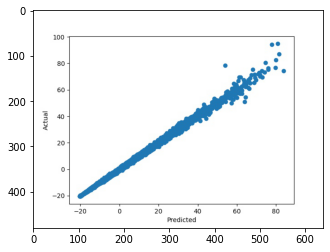

In [43]:
from mlflow.tracking.client import MlflowClient


client = MlflowClient()
query = f"tags.mlflow.parentRunId = '{run_id}'"
print(query)
runs = client.search_runs([exp_id],query)

best_mse = np.inf
best_iter=None
best_param=None
best_index=0


for indx,run in enumerate(runs):
    if best_mse > run.data.metrics['l2mean']:
        best_index=indx
        best_mse=run.data.metrics['l2mean']
        best_iter=run.data.metrics['iters']
        best_param=run.data.params
        
print(f"The best parameters found: {best_param}")
print(f"The optimal number of iterations with these parameters: {best_iter}")
print(f"The resulting MSE: {best_mse}")

img = mpimg.imread(runs[best_index].info.artifact_uri[7:]+'/scatter.jpeg')
imgplot = plt.imshow(img)

# We look at a scatterplot of predicted and actual to make sure there is sanity check on performance
plt.show()

#### Build the model using the best parameters and all the training data

In [21]:
lgb_params={ 'objective': 'regression',   
                'seed' :  762342, 
                'learning_rate': 0.1,
                'num_leaves':int(best_param['num_leaves']), 
                'verbose':-1, 
                'num_threads':15,
                'min_data_in_leaf':int(best_param['min_data_in_leaf'])
            }


lgb_train = lgb.Dataset(x_train,y_train,free_raw_data=False)
lgbm_mod = lgb.train(lgb_params,
                        lgb_train,
                        num_boost_round=int(best_iter), # use optimal iterations
                        verbose_eval=False)

#### Performance of final model on test set

In [22]:
preds=lgbm_mod.predict(x_test)

An application I wrote for showing the performance of a numeric regression model is called, passing in the actual and predicted values.

In [ ]:
numeric_perform_dash.create_num_dashboard(y_test,preds,x_test)

The performance of the model is shown below as an screen shot of the application called above (the real application will be within a local web page)

Here we look at multiple plots and metrics including a gains table, scatter plot, actual versus predicted histograms, metrics, plots for lift and the distribution of the actual and predicted.

In this case we see that the model rank orders exceptionally well, the calibration is nearly perfect and the prediction distributions are nearly identical to the actuals. In a real world problem, we could find areas for model improvement - especially running diagnostics on subsets of the data such as key stratiifcation segments. A model can also be used to predict the residuals and this resulting feature importance used to locate segments where additional data, feature engineering and perhaps weighting could be used to improve results. Here we are lacking any domain knowledge so the basic approach suffices.

<img src='./test_set_perform.JPG'></img>

#### Explore final model with Shap

We use Shap values to interpret the model. 

First we explore globable importance:

In [24]:
shap_values = shap.TreeExplainer(lgbm_mod).shap_values(x_test)

We see that the model is dominated by one principal feature (var_2) and there are three others with some relative impacts. The order of these features on the target and their general effect direction (marginally) are:

* var_2: Higher values are associated with higher predictions
* var_3: Higher values are associated with lower predictions
* var_9: Higher values are associated with higher predictions
* var_10: See below for this ordinal variable that has different impacts per level estimated

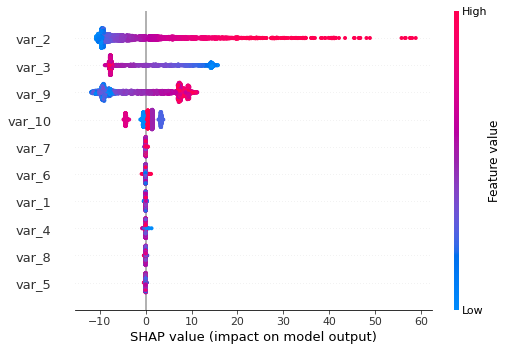

In [26]:
shap.summary_plot(shap_values, x_test)

* var_2 is generally associated in an exponential relationship with the target, where the contribution to the prediction becomes positive around a value of 5000
* We see some evidence that the model finds that for a given value of var_2, a higher value of var_9 produces a slightly higher prediction. We can explore this interaction in more detail below

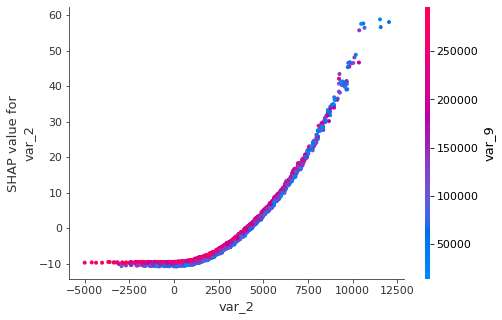

In [27]:
shap.dependence_plot("var_2", shap_values, x_test)

* The model finds a piecewise relationship between var_3 and the target, where the contribution to the prediction is relatively constant at around 15 units when var_3 is negative, the relationship is linearly decreasing sharply until around a var_3 value of 200000 where the contribution flattens out at around -8 

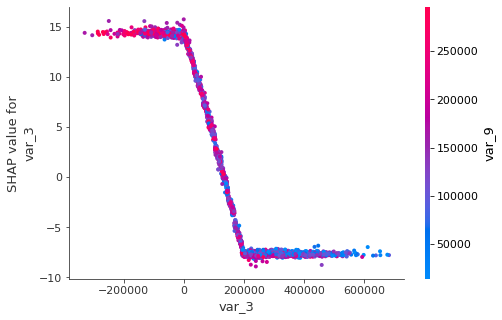

In [28]:
shap.dependence_plot("var_3", shap_values, x_test)

* The relationship between var_9 and the target is a mirror like image compared to var_3
* We see the evidence of interaction effect with vaer_3 here

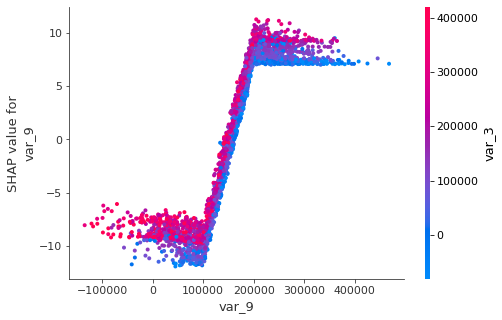

In [29]:
shap.dependence_plot("var_9", shap_values, x_test)

* With this model, we did not constrain the effect of var_10 to be monotonic, which we may prefer for the case of interpretability depending on its true nature (requires knowledge of the feature), but none-the-less we see that a value of 2 has the highest effect and 4 is the lowest effect

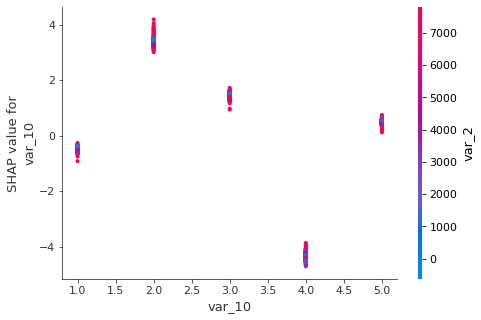

In [96]:
shap.dependence_plot("var_10", shap_values, x_test)

Another option of SHAP values are to include explicit interactions. Here we look to discern the interaction that appears between var_2 and var_9. The perceived interaction effect is shown even more explicitly here, as higher values of var_9 are shift upwards from lower values for any given value of var_2 

In [98]:
shap_interaction_values = shap.TreeExplainer(lgbm_mod).shap_interaction_values(x_test)

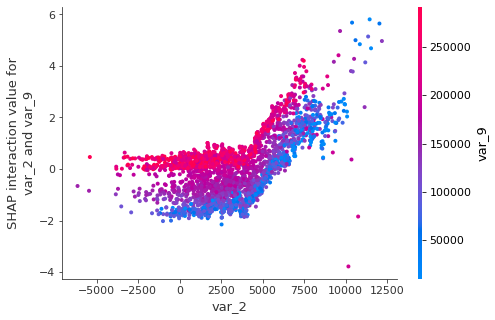

In [100]:

shap.dependence_plot(
    ("var_2", "var_9"),
    shap_interaction_values, x_test,
    display_features=x_test
)

Finally, we can explore the local interpretations for every record we perform infernce on - which will estimate in an additive fashion, the impact of every feature on the prediction from the model. In this way we can see how the value for each feature contribute to the overall prediction. This adds transparency, interpretability and also gives insights into why the model rewards or penalizes the prediction and under some circumstances, suggests ways to improve the predictions for an individual observation (if that were possible).

For the first observation in the test set:

* The large positive value for var_2 is the largest factor increasing the prediction for this observation (increasing from the mean prediction by 28.9 units)
* The large negative value for var_3 increases the prediction for this observation (increasing from the mean prediction by 14.7 units)
* The fact that var_10 has a value of 4, drives the score lower (decreasing from the mean prediction by 4 units)

In [44]:
shap.initjs()
print(f"Predicted Value: {lgbm_mod.predict(x_test)[0]}")
print(f"Intercept Value: {shap.TreeExplainer(lgbm_mod).expected_value}")
print(f"Demonstrating how prediction is decompsed by Shap value: {shap.TreeExplainer(lgbm_mod).expected_value+shap_values[0,:].sum()}")
display(pd.DataFrame(list(zip(x_test.columns,x_test.iloc[0,:],shap_values[0,:])),columns=['Feature','Feature Value','Shap Value']))
shap.force_plot(shap.TreeExplainer(lgbm_mod).expected_value, shap_values[0,:], x_test.iloc[0,:])

Predicted Value: 61.73418777857004
Intercept Value: [12.18455702]
Demonstrating how prediction is decompsed by Shap value: [61.73418778]


Feature  Feature Value  Shap Value
0   var_1   5.285077e+03   -0.064214
1   var_2   8.102610e+03   28.857380
2   var_3  -1.428025e+05   14.739389
3   var_4   7.318184e-01    0.063210
4   var_5   6.104569e+04   -0.002758
5   var_6   1.835028e+05    0.264415
6   var_7   2.418498e+06    0.204149
7   var_8   2.788060e+04   -0.084914
8   var_9   3.606268e+05    9.483917
9  var_10   4.000000e+00   -3.910944

This was a basic walkthrough of an approach to model the target using an ML algorithm and associated open source tools and infrastructure. In the real world there are many more aspects around validation, error analysis, producing uncertainity measures for the output if required (which can be done through various means using ML), we would likely seek to remove irrelevant features from the model, etc.

